100%|██████████| 9.91M/9.91M [00:00<00:00, 40.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.66MB/s]


Epoch 1, Loss: 166.2305
Epoch 2, Loss: 121.6513
Epoch 3, Loss: 114.6075
Epoch 4, Loss: 111.6447
Epoch 5, Loss: 109.8787
Epoch 6, Loss: 108.6867
Epoch 7, Loss: 107.8801
Epoch 8, Loss: 107.1625
Epoch 9, Loss: 106.6496
Epoch 10, Loss: 106.2501


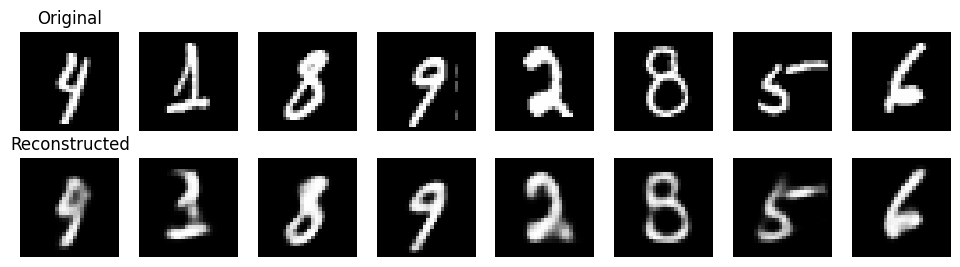

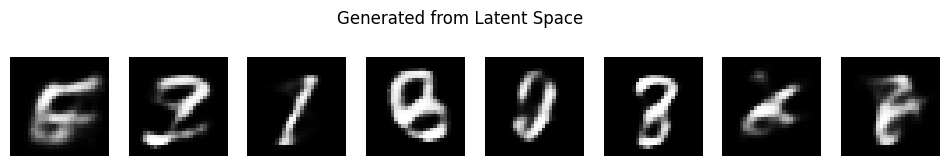

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
epochs = 10

# MNIST data
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Reparameterization trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 28*28)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat.view(-1, 1, 28, 28)

# VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Loss function
def loss_function(x_hat, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Initialize model
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(batch)
        loss = loss_function(x_hat, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

# Evaluation
vae.eval()

# Plot original vs reconstructed
def visualize_reconstruction():
    with torch.no_grad():
        sample = next(iter(train_loader))[0][:8].to(device)
        recon, _, _ = vae(sample)
        sample = sample.cpu()
        recon = recon.cpu()

        fig, axs = plt.subplots(2, 8, figsize=(12, 3))
        for i in range(8):
            axs[0, i].imshow(sample[i][0], cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i][0], cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_title("Original")
        axs[1, 0].set_title("Reconstructed")
        plt.show()

visualize_reconstruction()

# Generate samples from latent space
def visualize_generation():
    with torch.no_grad():
        z = torch.randn(8, latent_dim).to(device)
        generated = vae.decoder(z).cpu()

        fig, axs = plt.subplots(1, 8, figsize=(12, 2))
        for i in range(8):
            axs[i].imshow(generated[i][0], cmap='gray')
            axs[i].axis('off')
        plt.suptitle("Generated from Latent Space")
        plt.show()

visualize_generation()
